# COMS W4705 - Homework 4 
## Image Captioning with Conditioned LSTM Generators
Adapted from an assignment by Yassine Benajiba <yb2235@cs.columbia.edu>

Follow the instructions in this notebook step-by-step. Much of the code is provided, but some sections are marked with **todo**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Implement two `Dataset`s to return training instances (input/output sequence pairs) for language modeling and image captioning.
* Train an LSTM language generator on the captions.
* Implement a greedy decoder function for the language generator. 
* Train an LSTM caption generator on both the images and their captions. 
* Implement 1) a greedy decoder function, 2) a nucleus decoder function and 3) a beam search decoder for the image caption generator.
* Implement BLEU and use it to evaluate our trained model.

Please submit a copy of this notebook with your assignment, including all outputs. Do not submit any of the data files. 

### Getting Started 

First, let's configure this notebook to use GPUs.  While using a GPU is not a requirement, it will make the training scripts in this assignment run much faster and will allow you to iterate more rapidly.  It's also good practice as GPUs are an important part of the modern NLP toolkit.

To enable a GPU for this notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Below, we'll test that it worked.

In [1]:
import bisect
import collections
import os
import PIL
import types
import numpy as np
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive

import torch
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn import Module, Identity, Sequential, Embedding, Linear, LSTM, CrossEntropyLoss

import torchvision.models as models

if torch.cuda.is_available():
  print("Using GPU!")
  device = torch.device("cuda")
else:
  print("Using CPU... this is going to be slow...")
  device = torch.device("cpu")

/opt/conda/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


Using GPU!


### Autograding

We'll be using an autograder to evaluate some of the functions you implement below.  To ensure that the autograder works (it needs to be able to import your function implementations as strings): 

1.   Preserve the `AUTOGRADER TAG` comments you'll see below.  Please don't remove these comments -- we'll deduct points if they're missing (they're how we find the cell where you implemented each function).
2.   Don't access global variables inside any of the `AUTOGRADER TAG`ged functions (though using any of the imports above are fine); to assist you with this, we've tagged these functions with the decorator `noglobal` which will throw if you attempt to access any variables outside your function's scope.  Remove the decorator at your own peril!  If you need any additional imports in any of the `AUTOGRADER TAG`ged functions, please post exactly how to import them to the pinned EdStem thread "HOMEWORK 4 ADDITIONAL IMPORTS" and add them to the cell above.  We'll make sure we import them in the autograder.
3.   Finally, please keep the `AUTOGRADER TAG`ged functions in their own separate cells.  If you want to execute them, add a new cell to do so. 

We really appreciate your help in ensuring that the assignment is straightforward to grade.  It allows us to focus on assessing the correctness of your implementations instead of spending hours getting them to run!

In [2]:
# credit to https://gist.github.com/ax3l/59d92c6e1edefcef85ac2540eb056da3

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val

noglobal = lambda fn: types.FunctionType(fn.__code__, dict(imports()))

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

Professor Benajiba has uploaded all the data and model files you'll need to his GDrive and you can access the folder here:
https://drive.google.com/drive/folders/1i9Iun4h3EN1vSd1A1woez0mXJ9vRjFlT?usp=sharing

Google Drive does not allow copying a folder, so you'll need to download the whole folder and then upload it again to your own drive. Please assign the name you chose for this folder to the variable `my_data_dir` in the next cell.

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the data set beyond this course, we suggest that you submit your own download request here: https://forms.illinois.edu/sec/1713398

In [3]:
# This is where you put the name of your data folder.
# Please make sure it's correct because it'll be used in many places later.
my_data_dir="./nlp_hw4_data"

## Part I: Image Encodings

The files `Flickr_8k.trainImages.txt` and `Flickr_8k.devImages.txt` contain lists of training and development images. Let's load them. 

In [4]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [5]:
train_list = load_image_list(os.path.join(my_data_dir, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(my_data_dir, 'Flickr_8k.devImages.txt'))

Let's see how many images there are

In [6]:
len(train_list), len(dev_list)

(6000, 1000)

Each entry is an image filename.

In [7]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [8]:
IMG_DIR = "Flickr8k_Dataset"

We can use PIL to open the image and matplotlib to display it. 

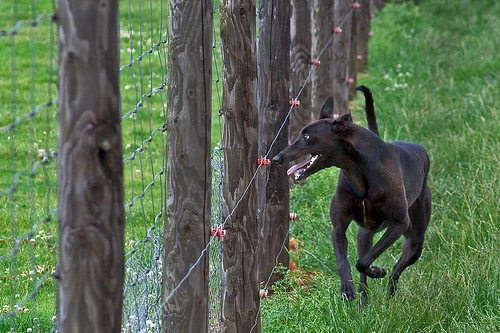

In [9]:
image = PIL.Image.open(os.path.join(my_data_dir, IMG_DIR, dev_list[20]))
image

if you can't see the image, try

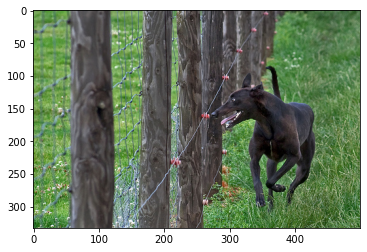

In [10]:
plt.imshow(image)


We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolutional neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [11]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [12]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

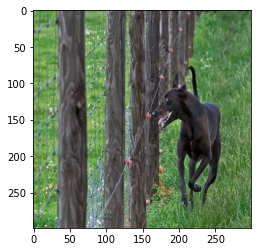

In [13]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [14]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [15]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(my_data_dir, IMG_DIR, image_name))
    return torch.tensor(np.transpose((np.asarray(image.resize((299,299))) / 255.0), axes=(2, 0, 1))).float()                 

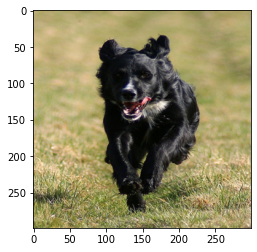

In [16]:
plt.imshow(np.transpose(get_image(dev_list[25]).numpy(), axes=(1, 2, 0)))

Next, we load the pre-trained Inception model. 

In [17]:
# This will download the weights for you
img_encoder = models.inception_v3(pretrained=True) 

This is a prediction model, so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We'll use the following hack: we'll replace the final classification layer with the identity function.

In [18]:
# We disable the final classification layer
img_encoder.fc = Identity()

# And we also disable dropout (by putting the model into eval mode)
img_encoder = img_encoder.to(device).eval()

Let's try the encoder. 

In [19]:
new_image = get_image(dev_list[20])
with torch.no_grad():
  encoded_image = img_encoder(new_image.unsqueeze(dim=0).to(device))

In [20]:
encoded_image

tensor([[0.2908, 0.5819, 0.0683,  ..., 0.7615, 0.9820, 0.4834]],
       device='cuda:0')

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset: train and dev).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator.  If you are unfamiliar with generators, take a look at this page from the Python official documentation: https://wiki.python.org/moin/Generators

Write the following generator function, which should return up to 256 images at a time. 
`img_list` is a list of image file names (i.e. the train or dev set). The return value should be a tensor of shape (256, 3, 299, 299).

In [21]:
BATCH_SIZE = 256

def img_generator(img_list):
    print("start {}, end {}".format(0, len(img_list)))
    for img_start_idx in range(0, len(img_list), BATCH_SIZE):
        batch_img = []

        for img_idx in range(img_start_idx, min(img_start_idx + BATCH_SIZE, 
                                                len(img_list))):

            new_image = get_image(img_list[img_idx])
#             print(new_image.shape)
            batch_img.append(new_image)

        yield torch.stack(batch_img)

Now we can encode all images (this takes 20 - 30 minutes...).

In [22]:
def encode_images(img_encoder, subset):
  encoded = []
  with torch.no_grad():
    for images in tqdm(img_generator(subset)):
      print("outer loop encode images: {}".format(images.shape))
      for image in img_encoder(images.to(device)).cpu():
        encoded.append(image)
#         print("inner loop encode images: {}".format(image.shape))
        
  return torch.stack(encoded, dim=0)



It's a good idea to save the resulting matrices so we don't have to run the encoder again. 

And now that we're done with the image encoder, we can clear it from the GPU.

In [23]:
# torch.save(enc_train, os.path.join(my_data_dir, "outputs/encoded_images_train.pt"))
# torch.save(enc_dev, os.path.join(my_data_dir, "outputs/encoded_images_dev.pt"))

enc_train_path = os.path.join(my_data_dir, "outputs/encoded_images_train.pt")
if os.path.isfile(enc_train_path):
    with open(enc_train_path, "rb") as file:
        enc_train = torch.load(file)
else:
    enc_train = encode_images(img_encoder, train_list)
    with open(enc_train_path, "wb") as file:
        torch.save(enc_train, file)
    
enc_dev_path = os.path.join(my_data_dir, "outputs/encoded_images_dev.pt")
if os.path.isfile(enc_dev_path):
    with open(enc_dev_path, "rb") as file:
        enc_dev = torch.load(file)
else:
    enc_dev = encode_images(img_encoder, dev_list)
    with open(enc_dev_path, "wb") as file:
        torch.save(enc_dev, file)

# Now, let's delete the image encoder and get some GPU RAM back!
# del img_encoder

In [24]:
enc_train.shape

torch.Size([6000, 2048])

## Part II Text (Caption) Data Preparation

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Take a look at the file `Flickr8k.token.txt` to understand its structure. Implement the function `read_image_descriptions` below.  It shoud read the image descriptions from the file `filename` and returns a dictionary in the following format:
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [25]:
# AUTOGRADER TAG: read_image_descriptions
@noglobal
def read_image_descriptions(_filename):    
    image_descriptions = defaultdict(list)    
    count = 0
    with open(_filename, "r") as file:
        lines = file.readlines()
        for line in lines:
            part1, caption = line.split("\t")
            img_filename, idx = part1.split("#")
            tokenized = ['<START>'] + caption.lower().split() + ['<END>']
            image_descriptions[img_filename].append(tokenized)
            count += 1
    return image_descriptions

In [26]:
descriptions = read_image_descriptions(os.path.join(my_data_dir, "Flickr8k.token.txt"))

In [27]:
print(descriptions[dev_list[0]])
descriptions[dev_list[0]] == [['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


True

Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

### Creating Word Indices (a Vocabulary)

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. 

**TODO**: create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [28]:
word_set = set()
for path, sents in descriptions.items():
    for sent in sents:
        for token in sent:
            word_set.add(token)
id_to_word = sorted(list(word_set))


In [29]:
word_to_id = {word: idx for idx, word in enumerate(id_to_word)}

In [30]:
# This should print an integer
word_to_id['dog'] 

2309

In [31]:
# This should print a token
id_to_word[1985] 

'crucified'

Note that we do not need an UNK word token as we are generating from our vocabulary. The generated text will only contain tokens seen at training time.  

## Part III Basic Decoder Model

For now, we will just train a model for text generation (a language model) without conditioning the generator on the image input. 

The core idea here is that the `torch` recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [32]:
MAX_LEN = max(
    len(description) for image_id in train_list 
    for description in descriptions[image_id]
)

assert MAX_LEN == 40

We will use our model to predict one word at a time, given a partial sequence (i.e., next word prediction). For example, given the partial sequence ["START","a"], the model might predict "dog" as the most likely next word. We'll use an LSTM to encode the partial sequence.


To build our training set, we will convert each description into a set of input, output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train our model using the following input/output pairs 

| i | input (partial sequence)     | output (next word) |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `.`  |
| 3 |[`START`,`a`, `black`, `dog`, `.`] | `END`  |



Here is the model in `torch`. Note that we are using a bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [33]:
class LanguageModel(Module):
  def __init__(self, device, vocab_size, embedding_dim, hidden_dim):
    super().__init__()
    self.device = device
    self.embeddings = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(
        embedding_dim, hidden_dim, num_layers=1, 
        bidirectional=True, batch_first=True
    )
    self.fc = Linear(2 * hidden_dim, vocab_size)
  
  def forward(self, seqs):
    seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
    embedded = self.embeddings(seqs)
    _, (h_n, _) = self.lstm(
        pack_padded_sequence(
            embedded, lengths=seq_lens, 
            batch_first=True, enforce_sorted=False
        )
    )
    hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
    return self.fc(hidden_states)

VOCAB_SIZE = len(word_to_id)
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
language_model = LanguageModel(device, VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE).to(device)

language_model

LanguageModel(
  (embeddings): Embedding(8920, 300)
  (lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=8920, bias=True)
)

The model input is a tensor of size `(BATCH_SIZE, MAX_LEN)`. Each row is a vector of size up to `MAX_LEN` in which each entry is an integer representing a word (according to the `word_to_id` dictionary). Any sequence shorter than the longest in the batch should be padded with `0`. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a tensor of size `(BATCH_SIZE, VOCAB_SIZE)`. `VOCAB_SIZE` is the number of vocabulary words. 

In [34]:
len(train_list), len(dev_list)

(6000, 1000)

### Creating a Dataset for the Training Data

**TODO**: We could simply create one large tensor for all the training data. Because we have a lot of training instances (each training sentence will produce up to `MAX_LEN` input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a `DataLoader`. To do so, we first need to implement a `Dataset`.

Implement the class `CaptionDataset` below that:

1 - takes a parameter `subset` (one of `train_list` or `dev_list`)

2 - implements `__getitem__(idx)` which returns an `(input, output)` pair. `input` is a partial input sequence encoded as a list of its indices in `word_to_id`, `output` contains the next word that should be predicted for the partial input sequence encoded as its index in `word_to_id`

3 - implements `__len__` which returns the total number of partial input sequences across the whole subset

If you've implemented `CaptionDataset` correctly, `len(CaptionDataset(descriptions, word_to_id, train_list))` should be equal to `383454`.


In [35]:
# AUTOGRADER TAG: CaptionDataset
class CaptionDataset(Dataset):
    @noglobal
    def __init__(self, _descriptions, _word_to_id, _subset):
        self.descriptions = _descriptions
        self.word_to_id = _word_to_id
        self.subset = _subset
        self.descriptions_word_id = []
        self.construct_idx_mapping()
        
        print("The length of descriptions_word_id: {}".format(len(self)))
        print("First instance: ", *self.descriptions_word_id[5])

    @noglobal
    def construct_idx_mapping(self):
        for img_id in self.subset:
            for des_id, description in enumerate(self.descriptions[img_id]):
                for token_id in range(1, len(description)):
                    instance = [
                                [self.word_to_id[token] for token in description[:token_id]], 
                                self.word_to_id[description[token_id]]
                               ]
                    # list of (input, output)
                    self.descriptions_word_id.append(instance)
                
    @noglobal 
    def __len__(self):
        return len(self.descriptions_word_id)

    @noglobal
    def __getitem__(self, idx):
        return self.descriptions_word_id[idx]

assert len(CaptionDataset(descriptions, word_to_id, train_list)) == 383454

The length of descriptions_word_id: 383454
First instance:  [69, 71, 802, 2309, 4012, 6485] 167


### Training the Model

Below is a simple training script for our language model.  We create a DataLoader for our training set and train the model for 10 epochs. As this is an introduction to language generation, we forgo monitoring its performance on the development set and accept the inevitable overfitting (but if we wanted to, we could calculate something like the model's BLEU on the development set and use that to guide early stopping).

In [36]:
def collate(batch):
  partial_sequences, continuations = [], []
  for (partial_sequence, continuation) in batch:
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  return (
      pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
      torch.tensor(continuations)
  )

batch_size = 4096
train_loader = DataLoader(
    CaptionDataset(descriptions, word_to_id, train_list), 
    collate_fn=collate, batch_size=batch_size, shuffle=True
)

optimizer = Adam(language_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
def handle_batch(model, criterion, batch):
    partial_captions, continuations = batch
    predictions = model(partial_captions.to(model.device))
    return criterion(predictions, continuations.to(model.device))

def train_basic_encoder():
    for epoch in range(10):
      t_tot_loss = 0.0
      language_model.train()
      for t_batch in tqdm(train_loader):
        optimizer.zero_grad()
        t_loss = handle_batch(language_model, criterion, t_batch)
        t_loss.backward()
        optimizer.step()

        t_tot_loss += t_loss.cpu().item()

      print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))
    

MODEL_PATH = "./basic_decoder_model.pb"
if os.path.isfile(MODEL_PATH):
    language_model = torch.load(MODEL_PATH).to(device)
else:
    train_basic_encoder()
    torch.save(language_model, MODEL_PATH)

The length of descriptions_word_id: 383454
First instance:  [69, 71, 802, 2309, 4012, 6485] 167


### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [37]:
# AUTOGRADER TAG: greedy_decoder
@torch.no_grad()
@noglobal
def greedy_decoder(_word_to_id, _id_to_word, _language_model, _max_len, _device):
    curr_token_ids = torch.tensor([_word_to_id["<START>"]]).unsqueeze(0).to(_device)
    curr_tokens = ["<START>"]
    while curr_token_ids[0][-1] != _word_to_id["<END>"] \
                    and curr_token_ids.shape[1] < _max_len:
        score = _language_model(curr_token_ids)
        next_token_id = torch.argmax(score, dim=1).unsqueeze(0)
        curr_token_ids = torch.cat([curr_token_ids, next_token_id], dim=1)
        next_token = _id_to_word[curr_token_ids[0, -1].item()]
        curr_tokens.append(next_token)
    return curr_tokens

In [38]:
print(greedy_decoder(word_to_id, id_to_word, language_model, MAX_LEN, device))

['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'curled', 'up', 'on', 'pavement', 'outdoors', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

## Part III - Conditioning on the Image

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the torch model looks like: 

In [39]:
class ImageCaptioningModel(Module):
  def __init__(self, device, vocab_size, embedding_dim, image_dim, hidden_dim):
    super().__init__()
    self.device = device
    self.embeddings = Embedding(vocab_size, embedding_dim)
    self.img_fc = Linear(image_dim, hidden_dim)
    self.lstm = LSTM(
        embedding_dim + hidden_dim, hidden_dim, num_layers=1, 
        bidirectional=True, batch_first=True
    )
    self.fc = Linear(2 * hidden_dim, vocab_size)
  
  def forward(self, images, seqs):
    seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
    rnn_input = torch.cat(
        (
            self.embeddings(seqs),
            torch.relu(self.img_fc(images)).unsqueeze(
                dim=1).repeat(1, seqs.shape[1], 1)
        ), dim=2
    )
    _, (h_n, _) = self.lstm(
        pack_padded_sequence(
            rnn_input, lengths=seq_lens, 
            batch_first=True, enforce_sorted=False
        )
    )
    hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
    return self.fc(hidden_states)

In [40]:
VOCAB_SIZE=len(word_to_id)
EMBEDDING_DIM=300
IMAGE_DIM=2048
HIDDEN_DIM=256
caption_model = ImageCaptioningModel(
    device, VOCAB_SIZE, EMBEDDING_DIM, IMAGE_DIM, HIDDEN_DIM).to(device)
caption_model.to(device)

ImageCaptioningModel(
  (embeddings): Embedding(8920, 300)
  (img_fc): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(556, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=8920, bias=True)
)

The model now takes two inputs: 
    
   1. a `(BATCH_SIZE, 2048)` tensor of image encodings. 
   2. a `(BATCH_SIZE, MAX_LEN)` tensor of partial input sequences. 
    
And one output as before: a `(BATCH_SIZE, VOCAB_SIZE)` tensor of predicted word distributions.   

**TODO**: Implement a new Dataset, `ImageCaptioningDataset`, that includes the image with each input/output pair. It needs to return a 3-tuple of `image_input, text_input, next_word` where each element is an array.  The `collate` function will handle converting them to tensors.

To implement this class, you need to find the image encoding that belongs to each image. Remember the indices in each `train_list` and `dev_list` match the indices in `enc_train` and `enc_dev`. 

If you have previously saved the image encodings, you can load them from disk: 

In [41]:
enc_train = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_train.pt")).to(device)
enc_dev = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_dev.pt")).to(device)

In [42]:
# AUTOGRADER TAG: ImageCaptioningDataset
class ImageCaptioningDataset(Dataset):
    @noglobal
    def __init__(self, _descriptions, _word_to_id, _subset, _image_encodings):
        self.subset = _subset
        self.word_to_id = _word_to_id
        self.descriptions = _descriptions
        self.batch = []
        self.img_encodings = _image_encodings
        self.construct_idx_mapping()

    @noglobal
    def construct_idx_mapping(self):
        for img_idx, img_id in enumerate(self.subset):
            for des_id, description in enumerate(self.descriptions[img_id]):
                for token_id in range(1, len(description)):
                    instance = [
                                self.img_encodings[img_idx],
                                [self.word_to_id[token] for token in description[:token_id]], 
                                self.word_to_id[description[token_id]]
                               ]
                    # list of (encoding, input, output)
                    self.batch.append(instance)

    @noglobal 
    def __len__(self):
        return len(self.batch)

    @noglobal  
    def __getitem__(self, idx):
        return self.batch[idx]

assert len(ImageCaptioningDataset(descriptions, word_to_id, train_list, enc_train)) == 383454

You should now be able to train our new model (again, we forgo monitoring performance on a development set -- you're welcome to add it!) 

In [43]:
def collate(batch):
  images, partial_sequences, continuations = [], [], []
  for (image, partial_sequence, continuation) in batch:
    images.append(image)
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  return (
      torch.stack(images), 
      pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
      torch.tensor(continuations)
  )

batch_size = 4096
train_loader = DataLoader(
    ImageCaptioningDataset(descriptions, word_to_id, train_list, enc_train), 
    collate_fn=collate, 
    batch_size=batch_size, 
    shuffle=True
)

optimizer = Adam(caption_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def handle_batch(model, criterion, batch):
  images, partial_captions, continuations = batch
  predictions = model(images.to(model.device), partial_captions.to(model.device))
  return predictions, criterion(predictions, continuations.to(model.device))

def train_caption_model():
    for epoch in range(20):
      t_tot_loss = 0.0
      caption_model.train()
      for t_batch in tqdm(train_loader):
        optimizer.zero_grad()
        _, t_loss = handle_batch(caption_model, criterion, t_batch)
        t_loss.backward()
        optimizer.step()

        t_tot_loss += t_loss.cpu().item()

      print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))


This may take a while. I strongly encourage you to use cloud GPUs for this part if you haven't yet!

Feel free to experiment with the parameters of the model or continue training the model. At some point, the model will overfit and will no longer produce good descriptions for the dev images. You can save your model weights to disk and continue at a later time. 

In [44]:
CAPTION_MODEL_PATH = os.path.join(my_data_dir, "outputs/model.pt")
if not os.path.isfile(CAPTION_MODEL_PATH):
    train_caption_model()
    torch.save(caption_model.state_dict(), CAPTION_MODEL_PATH)
else: 
    caption_model.load_state_dict(torch.load(os.path.join(my_data_dir, "outputs/model.pt")))
    caption_model = caption_model.to(device).eval()

### Greedy Decoder
**TODO**: Now we are ready to actually generate image captions using the trained model. Implement an update greedy decoder, adapting what you wrote for the text-only generator so that it takes an encoded image (a tensor of length `2048`) as input, and returns a text sequence.

In [45]:
# AUTOGRADER TAG: image_greedy_decoder
@torch.no_grad()
@noglobal
def image_greedy_decoder(_word_to_id, _id_to_word, _caption_model, 
                         _max_len, _device, seq_log_prob, _enc_image): 
    
    partial_captions = torch.tensor([_word_to_id["<START>"]]).unsqueeze(0).to(_device)
    partial_log_prob = torch.zeros(1, device=_device)
    _enc_image = _enc_image.unsqueeze(0).to(_caption_model.device)
    captions = ["<START>"]
    
    
    while partial_captions[0][-1] != _word_to_id["<END>"] \
                    and partial_captions.shape[1] < _max_len:
        
        score = _caption_model(_enc_image, partial_captions)
        log_prob = torch.log(torch.nn.functional.softmax(score, 1))
        next_token_id = torch.argmax(score, dim=1).unsqueeze(0).to(_caption_model.device)
        partial_captions = torch.cat([partial_captions, next_token_id], dim=1)
        partial_log_prob += log_prob[:, next_token_id].flatten()
        next_token = _id_to_word[partial_captions[0, -1].item()]
        captions.append(next_token)
    
    if seq_log_prob is not None:
        seq_log_prob.append(partial_log_prob)
        
    return captions

As a sanity check, you should now be able to reproduce (approximately) captions for the training images. 

['<START>', 'a', 'dog', 'is', 'running', 'through', 'the', 'snow', '.', '<END>']
[tensor([-7.3094], device='cuda:0')]


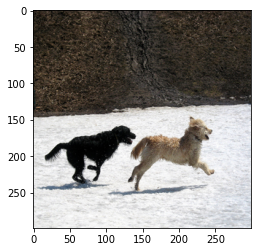

In [46]:
plt.imshow(np.transpose(get_image(train_list[0]).numpy(), axes=(1, 2, 0)))
log_prob = []
print(image_greedy_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, log_prob, enc_train[0]))
print(log_prob)

You should also be able to apply the model to dev images and get reasonable captions:

['<START>', 'a', 'football', 'player', 'in', 'a', 'white', 'shirt', 'is', 'running', 'with', 'a', 'football', 'field', '.', '<END>']
[tensor([-13.6287], device='cuda:0')]


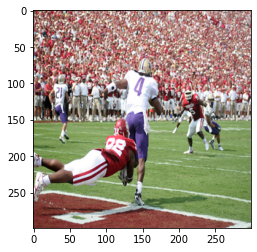

In [47]:
plt.imshow(np.transpose(get_image(dev_list[500]).numpy(), axes=(1, 2, 0)))
log_prob = []
print(image_greedy_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, log_prob, enc_dev[500]))
print(log_prob)

## Part IV - Beam Search and Nucleus Decoders

### Beam Search Decoder

**TODO** Modify the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the `n` highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). We recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the `n` most probable sequences. 

Then, for each sequence, compute the `n` most likely successor words. Append the word to produce `n` new sequences and compute their score. This way, you create a new list of `n*n` candidates. 

Prune this list to the best `n` as before and continue until `MAX_LEN` words have been generated. 

Note that you cannot use the occurence of the `"<END>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current `n`. 

In [48]:
# AUTOGRADER TAG: image_beam_decoder
@torch.no_grad()
@noglobal
def image_beam_decoder(_word_to_id, _id_to_word, _caption_model, 
                       _max_len, _device, n, seq_log_prob, _enc_image):
    _enc_image = _enc_image.to(_device)
    
    # initalizing partial_captions and prev_log_prob
    partial_captions = torch.tensor([_word_to_id["<START>"]]).unsqueeze(1).to(_device)
    prob = _caption_model(_enc_image.unsqueeze(0), partial_captions)
    prob = torch.nn.functional.softmax(prob, 1)
    log_prob = torch.log(prob)
    
    top_n = torch.topk(log_prob, n, dim=1)
    top_n_token_idx, top_n_token_log_prob = top_n.indices.T, top_n.values.T
    
    next_partial_captions = partial_captions.repeat(n, 1)
    next_curr_token = top_n_token_idx
    
    partial_captions = torch.cat([next_partial_captions, next_curr_token], dim=1)
    prev_log_prob = top_n_token_log_prob
    # end initialization
    
    prev_sum_log_prob = torch.clone(prev_log_prob)
    finished_captions = []
    finished_log_prob = []
    finished_sum_log_prob = []
    
    end_id = _word_to_id["<END>"]
    
    _enc_image = torch.stack([_enc_image] * n)
    
    while partial_captions.shape[0] > 0 and partial_captions.shape[1] < _max_len:
#         print("**************************************************")
        
#         # print shape
#         print("prev_log_prob", prev_log_prob.shape)
#         print("partial_captions", partial_captions.shape)
#         print(partial_captions)
    
        # calculate probability
        _enc_image = _enc_image[:partial_captions.shape[0], :]
        # print(_enc_image.shape)
        prob = _caption_model(_enc_image, partial_captions)
        prob = torch.nn.functional.softmax(prob, 1)
        log_prob = torch.log(prob)

        # get the top n token idx for each n cached sequence (hence nn)
        # print("====== nn ========")
        top_nn = torch.topk(log_prob, n, dim=1)
        top_nn_token_idx, top_nn_token_log_prob = top_nn.indices, top_nn.values
        # print("prev_log_prob", prev_log_prob)
        # print(" + ")
        # print("top_nn_token_log_prob", top_nn_token_log_prob)
        top_nn_token_log_prob = top_nn_token_log_prob + prev_log_prob
        # print(" = ")
        # print("top_nn_token_log_prob", top_nn_token_log_prob)

        # get the top n token idx among n^2 choices
        # print("====== n ========")
        top_n_token_log_prob_idx_flatten = torch.topk(top_nn_token_log_prob.flatten(), partial_captions.shape[0]).indices
        top_n_token_log_prob_idx = np.array(
            np.unravel_index(
                top_n_token_log_prob_idx_flatten.cpu().detach().numpy(),
                top_nn_token_log_prob.shape
            )
        ).T
        top_n_token_log_prob_idx = torch.tensor(top_n_token_log_prob_idx).to(_caption_model.device)

        # print("top_n_token_log_prob_idx_flatten", top_n_token_log_prob_idx_flatten)
        # print("top_n_token_log_prob_idx", top_n_token_log_prob_idx)

        # get the next capition and log probability
        # print("===== for loop end ======")
        
        next_partial_captions = torch.stack([partial_captions[prev_idx, :] for prev_idx, _ in top_n_token_log_prob_idx])
        next_curr_token = torch.take(top_nn_token_idx, top_n_token_log_prob_idx_flatten).unsqueeze(1)
        partial_captions = torch.cat([next_partial_captions, next_curr_token], dim=1)
        end_filter_idx = partial_captions[:, -1] == end_id
        # print("== END", end_filter_idx)
        
        prev_log_prob = torch.take(top_nn_token_log_prob, top_n_token_log_prob_idx_flatten).unsqueeze(1) # n x 1 
        prev_sum_log_prob += prev_log_prob
        
        if end_filter_idx.any():
            finished_captions.extend(torch.split(partial_captions[end_filter_idx], 1))
            finished_log_prob.extend(torch.split(prev_log_prob[end_filter_idx], 1))
            finished_sum_log_prob.extend(torch.split(prev_sum_log_prob[end_filter_idx], 1))
            
            partial_captions = partial_captions[~ end_filter_idx]
            prev_log_prob = prev_log_prob[~end_filter_idx]
            prev_sum_log_prob = prev_sum_log_prob[~end_filter_idx]
            
        # print("prev_log_prob", prev_log_prob)
        # print("partial_captions", partial_captions)
        # print("finished_captions", finished_captions)
        # print("finished_log_prob", finished_log_prob)
        
    
    if partial_captions.shape[0]:
        finished_captions.extend(torch.split(partial_captions, 1))
        finished_log_prob.extend(torch.split(prev_log_prob, 1))
        finished_sum_log_prob.extend(torch.split(prev_sum_log_prob, 1))
        
    finished_log_prob = torch.tensor(finished_log_prob)
    finished_sum_log_prob = torch.tensor(finished_sum_log_prob)
    finished_len = torch.tensor([cap.shape[1] for cap in finished_captions])
    finished_norm_log_prob = finished_sum_log_prob / finished_len
    
    best_caption_idx = torch.argmax(finished_norm_log_prob, dim=0)
    
    if seq_log_prob is not None:
        seq_log_prob.append(finished_norm_log_prob[best_caption_idx].flatten())
    
    return [_id_to_word[token_id] for token_id in finished_captions[best_caption_idx].flatten()]
    
# plt.imshow(np.transpose(get_image(dev_list[100]).numpy(), axes=(1, 2, 0)))
# print(image_beam_decoder(word_to_id, id_to_word, caption_model, 10, device, 4, enc_dev[100]))


['<START>', 'a', 'baseball', 'player', 'slides', 'to', 'hit', 'the', 'ball', '.', '<END>']
[tensor([-4.4816])]


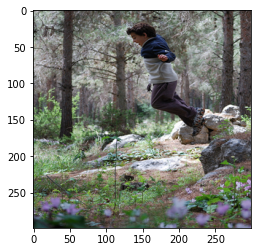

In [49]:
plt.imshow(np.transpose(get_image(dev_list[1]).numpy(), axes=(1, 2, 0)))
log_prob = []
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 10, log_prob, enc_dev[100]))
print(log_prob)

['<START>', 'a', 'baseball', 'player', 'is', 'running', 'after', 'the', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'runs', 'on', 'the', 'field', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'slides', 'to', 'hit', 'the', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'hitting', 'the', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'runs', 'for', 'the', 'ball', '.', '<END>']


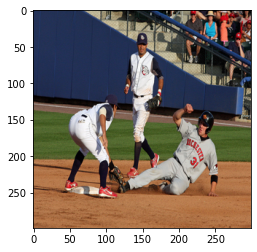

In [50]:
plt.imshow(np.transpose(get_image(dev_list[100]).numpy(), axes=(1, 2, 0)))
# print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 1, enc_dev[100]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 3, [], enc_dev[100]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 5, [], enc_dev[100]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 10,[],  enc_dev[100]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 15,[],  enc_dev[100]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 20,[],  enc_dev[100]))


### Nucleus Decoder

**TODO** Now, let's implement another decoder. Rather than selecting the top `n` tokens at each decoding step, we could sample the next word from the distribution (i.e. the softmax activated output) returned by the model. This allows us to incorporate some randomness into the decoding process.  Below, we'll implement a specific sampling-based decoding strategy: nucleus sampling.  

In nucleus sampling \[[Holtzman et al., 2019](https://arxiv.org/abs/1904.09751)\], at each decoding step, we only consider the smallest subset of the vocabulary tokens whose cumulative probability mass reaches a predefined threshold `p` (the "nucleus" of the distribution).  The probability mass of truncated tokens is then redistributed to the selected tokens.  We sample the next word from this re-normalized truncated distribution.  

Implement nucleus sampling below.  To sample from a distribution, consider  [torch.distributions.Categorical](https://pytorch.org/docs/stable/distributions.html). 

In [51]:
# AUTOGRADER TAG: image_nucleus_decoder
@torch.no_grad()
@noglobal
def image_nucleus_decoder(_word_to_id, _id_to_word, _caption_model,
                          _max_len, _device, p, seq_log_prob, _enc_image):
    
    partial_captions = torch.tensor([_word_to_id["<START>"]]).unsqueeze(0).to(_device)
    partial_log_prob = torch.zeros(1, device=_device)
    _enc_image = _enc_image.unsqueeze(0).to(_caption_model.device)
    captions = ["<START>"]
    
    while partial_captions[0][-1] != _word_to_id["<END>"] \
                    and partial_captions.shape[1] < _max_len:
        score = _caption_model(_enc_image, partial_captions)
        prob = torch.nn.functional.softmax(score, 1)
        sort_prob, sort_idx = torch.sort(prob, descending=True)
        cum_prob = torch.cumsum(sort_prob, dim=1)
        
        sort_idx_to_remove = cum_prob > p
        sort_idx_to_remove[:, 1:] = sort_idx_to_remove[:, :-1].clone()
        sort_idx_to_remove[:, 0] = 0
        
        sort_prob[sort_idx_to_remove] = 0
        prob_mass = torch.sum(sort_prob, dim=1)
        sort_prob[~sort_idx_to_remove] /= prob_mass
        sort_next_idx = sort_prob.multinomial(1).view(-1, 1)
        next_token_idx = torch.gather(sort_idx, dim=1, index=sort_next_idx)
        next_token_prob = torch.gather(sort_prob, dim=1, index=sort_next_idx)
        
        partial_captions = torch.cat([partial_captions, next_token_idx], dim=1)
        partial_log_prob += torch.log(next_token_prob.flatten())
        next_token = _id_to_word[partial_captions[0, -1].item()]
        captions.append(next_token)
        
    if seq_log_prob is not None:
        seq_log_prob.append(partial_log_prob)
    return captions



Now, let's see what kind of output we get:

['<START>', 'a', 'football', 'player', 'running', 'on', 'the', 'field', 'with', 'a', 'crowd', 'of', 'football', 'players', 'run', 'down', 'the', 'field', '.', '<END>']
['<START>', 'of', 'soccer', 'players', 'about', 'to', 'get', 'a', 'ball', 'from', 'the', 'other', 'in', 'a', 'game', '.', '<END>']
['<START>', 'children', 'run', 'across', 'a', 'football', 'game', 'with', 'just', 'plays', 'the', 'ball', '.', '<END>']
['<START>', 'football', 'player', 'in', 'orange', 'shirt', 'kicks', 'red', 'ball', 'in', 'mid-jump', 'field', '<END>']
['<START>', 'the', 'player', 'wearing', 'purple', 'runs', 'out', 'the', 'football', 'in', 'the', 'field', '.', '<END>']
[tensor([-20.0813], device='cuda:0'), tensor([-29.8056], device='cuda:0'), tensor([-37.1869], device='cuda:0'), tensor([-28.2141], device='cuda:0'), tensor([-29.0062], device='cuda:0')]


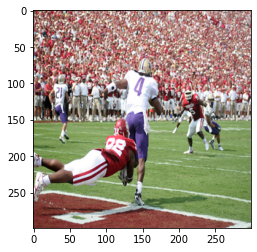

In [52]:
plt.imshow(np.transpose(get_image(dev_list[500]).numpy(), axes=(1, 2, 0)))
log_prob = []

for i in range(5): 
    print(image_nucleus_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 0.95, log_prob, enc_dev[500]))
    
print(log_prob)

## Part V - BLEU and Evaluation

Finally, let's evaluate our trained model on our development set.  A standard evaluation metric in language generation tasks in BLEU.  Please consult the written assignment description for an introduction to BLEU.  While libraries exist that will calculate it for you, for this assignment you'll need to implement it yourself.  We'll use your implementation to evaluate the performance of the various decoding strategies on the development set.

### Calculate BLEU

**TODO** Implement `bleu` below.  Candidate should be a list of words (the generated caption).  References should be a list of lists of words (the gold label captions).  Weights should be our `n`-gram specific weights (and its length should determine the range of `n`-grams to use!)

In [108]:
# AUTOGRADER TAG: bleu
@noglobal
def get_ngram_count(n, sent):
    left, right = 0, n - 1
    ngrams = []
    while right < len(sent):
        ngrams.append(tuple(sent[left: right + 1]))
        left += 1
        right += 1
    return collections.Counter(ngrams)

@noglobal
def bleu(_candidate, _references, _weights):
    # print("[bleu: bevity] candidate: {} \n reference: {}".format(_candidate, _references))
    _candidate = [_candidate]
    nc, nr = len(_candidate), len(_references)
    c_len, r_len = [len(sent) for sent in _candidate], sorted([len(sent) for sent in _references])
    n_gram = len(_weights)

    # brevity
    bp = []
    for c_idx, c in enumerate(c_len):
        mid_r_idx = bisect.bisect_right(r_len, c)
        poss_r_idx = [max(0, mid_r_idx - 1), min(mid_r_idx, len(r_len) - 1), min(mid_r_idx + 1, len(r_len) - 1)]
        r_idx = min(poss_r_idx, key=lambda r_idx: abs(r_len[r_idx] - c))
        r = r_len[r_idx]
        if c > r:
            bp.append(1)
        else:
            bp.extend(np.exp([1 - r / c]))
            
    # print("[bleu: bevity] {}".format(bp))
    # precision
    r_ngram_count = [[get_ngram_count(n, sent) for n in range(1, n_gram + 1)]
                     for sent in _references]
    c_ngram_count = [[get_ngram_count(n, sent) for n in range(1, n_gram + 1)]
                     for sent in _candidate]
    avg_precision = []
    for c_idx in range(nc):
        avg_table = [0] * n_gram
        avg = [0] * n_gram
        
        for n in range(n_gram):
            ngram_avg = 0
            
            for gram in c_ngram_count[c_idx][n].keys():
                p = min(max(r_ngram_count[r_idx][n][gram] for r_idx in range(nr)),
                        c_ngram_count[c_idx][n][gram])
                # print("[bleu: {}-gram looping] {} min count {}".format(n, gram, p))
                ngram_avg += p
#                 TODO: NEED TO CHANGE
            # print("[bleu: {} looping] total ngram counts: {}".format(n, ngram_avg))
            ngram_avg /= len(c_ngram_count[c_idx][n])
        
            if ngram_avg != 0:
                avg[n] = np.log(ngram_avg)
                avg_table[n] = np.log(ngram_avg)
            else:
                for i in range(1, n + 1):
                    prev_n = n - i
                    if avg_table[prev_n] != 0:
                        avg[n] = avg_table[prev_n]
                        break
            # print("[bleu: {} looping] avg_table: {}".format(n, avg_table))
            # print("[bleu: {} looping] av: {}".format(n, avg))
                
        non_0_count = sum(1 if a != 0 else 0 for a in avg_table)
        unit_w = 1 / non_0_count if non_0_count != 0 else 0
        weighted_avg = [a * unit_w for a in avg_table]
        # print("unit_w: {}, weighted avg: {}".format(unit_w, weighted_avg))
        
        avg_precision.append(np.exp(sum(weighted_avg)))
        
    # print("[bleu: avg_precision] {}".format(avg_precision))
    return [a * b for a, b in zip(avg_precision, bp)]

Now let's evaluate our various decoders.

In [109]:
def evaluate(decoder):
  bleu_scores = []
  caption_model.eval()
  for d_image, d_enc in zip(dev_list, enc_dev):
    bleu_scores.append(bleu(
        decoder(d_enc),
        descriptions[d_image],
        [1/4, 1/4, 1/4, 1/4]
    ))
  return np.mean(bleu_scores)

greedy_seq_log_probs = []
beam_3_seq_log_probs = []
beam_5_seq_log_probs = []
nucleus_95_seq_log_probs = []

for (name, decoder) in [
  ('greedy', partial(image_greedy_decoder, word_to_id, id_to_word,
                     caption_model, MAX_LEN, device, greedy_seq_log_probs)),
  ('beam-3', partial(image_beam_decoder, word_to_id, id_to_word,
                     caption_model, MAX_LEN, device, 3, beam_3_seq_log_probs)),
  ('beam-5', partial(image_beam_decoder, word_to_id, id_to_word,
                     caption_model, MAX_LEN, device, 5, beam_5_seq_log_probs)),
  ('nucleus-0.95', partial(image_nucleus_decoder, word_to_id, id_to_word,
                        caption_model, MAX_LEN, device, 0.95, nucleus_95_seq_log_probs))
]:
  print(name, evaluate(decoder))


greedy 0.3346629700423026
beam-3 0.35534421627895046
beam-5 0.3639738444407656
nucleus-0.95 0.27873231112446134


## Extra Credit - Roscuo

In [55]:
# split
@noglobal
def load_image_roscoe_list(_filename):    
    ro_list = []
    ro_dir = os.path.dirname(_filename)
    
    image_descriptions = defaultdict(list)    
    with open(_filename, "r") as file:
        ro_list = list(map(lambda line: line.rstrip().split("\t"), file.readlines()))

    np.random.seed(1)
    ro_idx = np.random.permutation(len(ro_list))
    split_idx = int(0.8 * len(ro_list))
    train_ro_idx, dev_ro_idx = ro_idx[:split_idx], ro_idx[split_idx:]

    train_ro_list = [os.path.join(ro_dir, ro_list[idx][0]) for idx in train_ro_idx]
    dev_ro_list = [os.path.join(ro_dir, ro_list[idx][0]) for idx in dev_ro_idx]
    
    return train_ro_list, dev_ro_list

@noglobal
def get_roscoe_image(image_name):
    image = PIL.Image.open(image_name)
    return torch.tensor(np.transpose((np.asarray(image.resize((299,299))) / 255.0), axes=(2, 0, 1))).float()                 

@noglobal
def roscoe_img_generator(img_list):
    BATCH_SIZE = 256
    print("start {}, end {}".format(0, len(img_list)))
    for img_start_idx in range(0, len(img_list), BATCH_SIZE):
        batch_img = []

        for img_idx in range(img_start_idx, min(img_start_idx + BATCH_SIZE, 
                                                len(img_list))):

            new_image = get_roscoe_image(img_list[img_idx])
#             print(new_image.shape)
            batch_img.append(new_image)

        yield torch.stack(batch_img)

def encode_roscoe_images(img_encoder, subset):
  encoded = []
  with torch.no_grad():
    for images in tqdm(roscoe_img_generator(subset)):
      print("outer loop encode images: {}".format(images.shape))
      for image in img_encoder(images.to(device)).cpu():
        encoded.append(image)
#         print("inner loop encode images: {}".format(image.shape))
        
  return torch.stack(encoded, dim=0)

@noglobal
def read_roscoe_image_descriptions(_filename):    
    image_descriptions = defaultdict(list)    
    count = 0
    with open(_filename, "r") as file:
        lines = file.readlines()
        for line in lines:
            img_filename, caption = line.split("\t")
            tokenized = ['<START>'] + caption.lower().split() + ['<END>']
            image_descriptions[img_filename].append(tokenized)
            count += 1
    return image_descriptions


In [56]:
train_ro_list, dev_ro_list = load_image_roscoe_list("/home/bobby/roscoe/captions2.txt")
print(len(train_ro_list), len(dev_ro_list))

34 9


In [57]:
enc_dev_ro_path = os.path.join(my_data_dir, "outputs/encoded_images_roscoe_dev_ro.pt")
if os.path.isfile(enc_dev_ro_path):
    with open(enc_dev_ro_path, "rb") as file:
        enc_dev_ro = torch.load(file)
else:
    enc_dev_ro = encode_roscoe_images(img_encoder, dev_ro_list)
    with open(enc_dev_ro_path, "wb") as file:
        torch.save(enc_dev_ro, file)
        
enc_train_ro_path = os.path.join(my_data_dir, "outputs/encoded_images_roscoe_train_ro.pt")
if os.path.isfile(enc_train_ro_path):
    with open(enc_train_ro_path, "rb") as file:
        enc_train_ro = torch.load(file)
else:
    enc_train_ro = encode_roscoe_images(img_encoder, train_ro_list)
    with open(enc_train_ro_path, "wb") as file:
        torch.save(enc_train_ro, file)


roscoe_descriptions = read_roscoe_image_descriptions("/home/bobby/roscoe/captions2.txt")


In [63]:
# update global training inputs

enc_train = torch.cat([enc_train, enc_train_ro])
enc_dev = torch.cat([enc_dev, enc_dev_ro])

dev_ro_list = list(map(os.path.basename, dev_ro_list))
train_ro_list = list(map(os.path.basename, train_ro_list))

train_list.extend(train_ro_list)
dev_list.extend(dev_ro_list)

descriptions.update(roscoe_descriptions)


aug_word_set = set()
for path, sents in descriptions.items():
    for sent in sents:
        for token in sent:
            aug_word_set.add(token)
aug_id_to_word = sorted(list(aug_word_set))
aug_word_to_id = {word: idx for idx, word in enumerate(aug_id_to_word)}
orig_id_to_word, orig_word_to_id = id_to_word, word_to_id

In [64]:
VOCAB_SIZE=len(aug_word_to_id)
EMBEDDING_DIM=300
IMAGE_DIM=2048
HIDDEN_DIM=256
aug_caption_model = ImageCaptioningModel(
    device, VOCAB_SIZE, EMBEDDING_DIM, IMAGE_DIM, HIDDEN_DIM).to(device)
aug_caption_model.to(device)

ImageCaptioningModel(
  (embeddings): Embedding(8930, 300)
  (img_fc): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(556, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=8930, bias=True)
)

In [66]:
# train conditional encoder

def collate(batch):
  images, partial_sequences, continuations = [], [], []
  for (image, partial_sequence, continuation) in batch:
    images.append(image)
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  return (
      torch.stack(images), 
      pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
      torch.tensor(continuations)
  )

batch_size = 4096
train_loader = DataLoader(
    ImageCaptioningDataset(descriptions, aug_word_to_id, train_list, enc_train), 
    collate_fn=collate, 
    batch_size=batch_size, 
    shuffle=True
)

optimizer = Adam(aug_caption_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def handle_batch(model, criterion, batch):
  images, partial_captions, continuations = batch
  predictions = model(images.to(model.device), partial_captions.to(model.device))
  return predictions, criterion(predictions, continuations.to(model.device))

def train_aug_caption_model():
    for epoch in range(20):
      t_tot_loss = 0.0
      aug_caption_model.train()
      for t_batch in tqdm(train_loader):
        optimizer.zero_grad()
        _, t_loss = handle_batch(aug_caption_model, criterion, t_batch)
        t_loss.backward()
        optimizer.step()

        t_tot_loss += t_loss.cpu().item()

      print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))

CAPTION_ROSCOE_MODEL_PATH = os.path.join(my_data_dir, "outputs/roscoe_model.pt")
if not os.path.isfile(CAPTION_ROSCOE_MODEL_PATH):
    train_aug_caption_model()
    torch.save(aug_caption_model.state_dict(), CAPTION_ROSCOE_MODEL_PATH)
else: 
    aug_caption_model.load_state_dict(torch.load(os.path.join(my_data_dir, "outputs/roscoe_model.pt")))
    aug_caption_model = aug_caption_model.to(device).eval()

In [72]:
image_beam_decoder(orig_word_to_id, orig_id_to_word, caption_model, MAX_LEN, device, 5, [], enc_dev_ro[-1])

['<START>', 'a', 'dog', 'in', 'the', 'snow', '.', '<END>']

In [100]:
bleu(image_beam_decoder(orig_word_to_id, orig_id_to_word, caption_model, MAX_LEN, device, 5, [], enc_dev_ro[-1]), descriptions[dev_ro_list[-1]], [1/4] * 4)

[bleu: bevity] candidate: ['<START>', 'a', 'dog', 'in', 'the', 'snow', '.', '<END>'] 
 reference: [['<START>', 'roscoe', 'on', 'a', 'boat', '<END>']]
[bleu: 0-gram looping] ('<START>',) min count 1
[bleu: 0-gram looping] ('a',) min count 1
[bleu: 0-gram looping] ('dog',) min count 0
[bleu: 0-gram looping] ('in',) min count 0
[bleu: 0-gram looping] ('the',) min count 0
[bleu: 0-gram looping] ('snow',) min count 0
[bleu: 0-gram looping] ('.',) min count 0
[bleu: 0-gram looping] ('<END>',) min count 1
[bleu: 0 looping] total ngram counts: 3
[bleu: 0 looping] avg_table: [-0.9808292530117262, 0, 0, 0]
[bleu: 0 looping] av: [-0.9808292530117262, 0, 0, 0]
[bleu: 1-gram looping] ('<START>', 'a') min count 0
[bleu: 1-gram looping] ('a', 'dog') min count 0
[bleu: 1-gram looping] ('dog', 'in') min count 0
[bleu: 1-gram looping] ('in', 'the') min count 0
[bleu: 1-gram looping] ('the', 'snow') min count 0
[bleu: 1-gram looping] ('snow', '.') min count 0
[bleu: 1-gram looping] ('.', '<END>') min cou

[0.375]

In [98]:
print(
image_beam_decoder(aug_word_to_id, aug_id_to_word,
                 aug_caption_model, MAX_LEN, device, 5, [], enc_dev_ro[0])
)
print(descriptions[dev_ro_list[0]])

['<START>', 'roscoe', 'on', 'a', 'sidewalk', '<END>']
[['<START>', 'roscoe', 'rests', 'near', 'trees', '<END>']]


In [101]:
bleu(image_beam_decoder(aug_word_to_id, aug_id_to_word, aug_caption_model, MAX_LEN, device, 5, [], enc_dev_ro[0]), descriptions[dev_ro_list[0]], [1/4] * 4)

[bleu: bevity] candidate: ['<START>', 'roscoe', 'on', 'a', 'sidewalk', '<END>'] 
 reference: [['<START>', 'roscoe', 'rests', 'near', 'trees', '<END>']]
[bleu: 0-gram looping] ('<START>',) min count 1
[bleu: 0-gram looping] ('roscoe',) min count 1
[bleu: 0-gram looping] ('on',) min count 0
[bleu: 0-gram looping] ('a',) min count 0
[bleu: 0-gram looping] ('sidewalk',) min count 0
[bleu: 0-gram looping] ('<END>',) min count 1
[bleu: 0 looping] total ngram counts: 3
[bleu: 0 looping] avg_table: [-0.6931471805599453, 0, 0, 0]
[bleu: 0 looping] av: [-0.6931471805599453, 0, 0, 0]
[bleu: 1-gram looping] ('<START>', 'roscoe') min count 1
[bleu: 1-gram looping] ('roscoe', 'on') min count 0
[bleu: 1-gram looping] ('on', 'a') min count 0
[bleu: 1-gram looping] ('a', 'sidewalk') min count 0
[bleu: 1-gram looping] ('sidewalk', '<END>') min count 0
[bleu: 1 looping] total ngram counts: 1
[bleu: 1 looping] avg_table: [-0.6931471805599453, -1.6094379124341003, 0, 0]
[bleu: 1 looping] av: [-0.6931471805

[0.316227766016838]

### Question 1

In [102]:
dev_ro_list

['roscoe17.jpeg',
 'roscoe1.jpg',
 'roscoe16.jpeg',
 'roscoe6.jpeg',
 'roscoe12.JPG',
 'roscoe10.JPG',
 'roscoe9.jpeg',
 'roscoe13.jpeg',
 'roscoe38.jpeg']

In [111]:
def evaluate_roscoe(decoder):
  bleu_scores = []
  caption_model.eval()
  for d_image, d_enc in zip(dev_ro_list, enc_dev_ro):
    bleu_scores.append(bleu(
        decoder(d_enc),
        descriptions[d_image],
        [1/4, 1/4, 1/4, 1/4]
    ))
  return np.mean(bleu_scores)

greedy_seq_log_probs = []
beam_3_seq_log_probs = []
beam_5_seq_log_probs = []
nucleus_95_seq_log_probs = []

print("augmented caption model")

for (name, decoder) in [
  ('greedy', partial(image_greedy_decoder, aug_word_to_id, aug_id_to_word,
                     aug_caption_model, MAX_LEN, device, greedy_seq_log_probs)),
  ('beam-3', partial(image_beam_decoder, aug_word_to_id, aug_id_to_word,
                     aug_caption_model, MAX_LEN, device, 3, beam_3_seq_log_probs)),
  ('beam-5', partial(image_beam_decoder, aug_word_to_id, aug_id_to_word,
                     aug_caption_model, MAX_LEN, device, 5, beam_5_seq_log_probs)),
  ('nucleus-0.95', partial(image_nucleus_decoder, aug_word_to_id, aug_id_to_word,
                        aug_caption_model, MAX_LEN, device, 0.95, nucleus_95_seq_log_probs))
]:
  print(name, evaluate_roscoe(decoder))


print()
print("original caption model")
for (name, decoder) in [
  ('greedy', partial(image_greedy_decoder, orig_word_to_id, orig_id_to_word,
                     caption_model, MAX_LEN, device, greedy_seq_log_probs)),
  ('beam-3', partial(image_beam_decoder, orig_word_to_id, orig_id_to_word,
                     caption_model, MAX_LEN, device, 3, beam_3_seq_log_probs)),
  ('beam-5', partial(image_beam_decoder, orig_word_to_id, orig_id_to_word,
                     caption_model, MAX_LEN, device, 5, beam_5_seq_log_probs)),
  ('nucleus-0.95', partial(image_nucleus_decoder, orig_word_to_id, orig_id_to_word,
                     caption_model, MAX_LEN, device, 0.95, nucleus_95_seq_log_probs))
]:
  print(name, evaluate_roscoe(decoder))

augmented caption model
greedy 0.2123647503094529
beam-3 0.24927790424066668
beam-5 0.2494408111720182
nucleus-0.95 0.22921385414876225

original caption model
greedy 0.21170489754577737
beam-3 0.23775939860027842
beam-5 0.24238902822990807
nucleus-0.95 0.23206152253163173


### Question 2

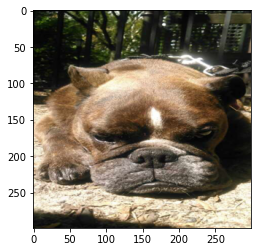

0
original model
['<START>', 'a', 'brown', 'dog', 'is', 'licking', 'its', 'nose', '.', '<END>']
augmented model
['<START>', 'roscoe', 'on', 'a', 'sidewalk', '<END>']


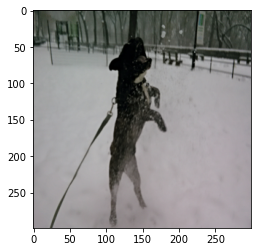

1
original model
['<START>', 'a', 'dog', 'jumps', 'to', 'catch', 'a', 'snowball', '.', '<END>']
augmented model
['<START>', 'a', 'dog', 'jumps', 'in', 'the', 'snow', '.', '<END>']


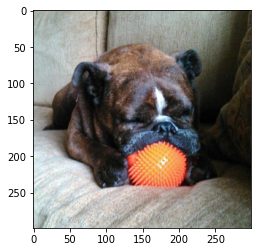

2
original model
['<START>', 'a', 'brown', 'dog', 'is', 'licking', 'its', 'nose', '.', '<END>']
augmented model
['<START>', 'roscoe', 'sleeps', 'in', 'pillows', '<END>']


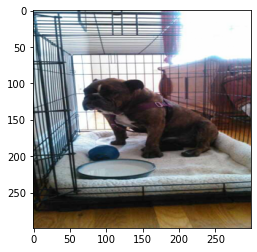

3
original model
['<START>', 'two', 'dogs', 'playing', 'with', 'each', 'other', '.', '<END>']
augmented model
['<START>', 'two', 'dogs', 'playing', 'in', 'a', 'house', '.', '<END>']


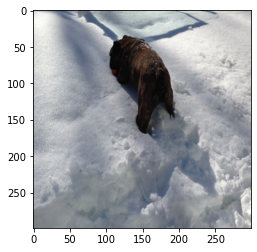

4
original model
['<START>', 'a', 'brown', 'and', 'white', 'dog', 'is', 'in', 'the', 'snow', '.', '<END>']
augmented model
['<START>', 'a', 'brown', 'dog', 'in', 'the', 'snow', '.', '<END>']


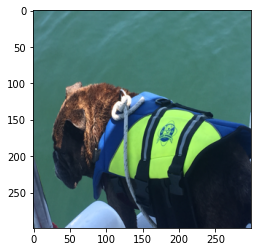

5
original model
['<START>', 'a', 'brown', 'dog', 'is', 'laying', 'in', 'the', 'water', '.', '<END>']
augmented model
['<START>', 'a', 'brown', 'dog', 'is', 'shaking', 'off', 'water', '.', '<END>']


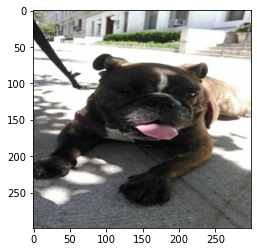

6
original model
['<START>', 'a', 'brown', 'dog', 'is', 'licking', 'its', 'nose', '.', '<END>']
augmented model
['<START>', 'roscoe', 'on', 'a', 'sidewalk', '.', '<END>']


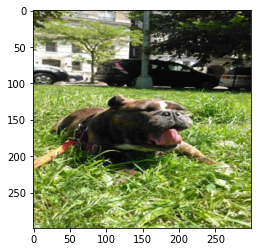

7
original model
['<START>', 'a', 'brown', 'dog', 'is', 'playing', 'with', 'a', 'red', 'ball', '.', '<END>']
augmented model
['<START>', 'a', 'brown', 'dog', 'is', 'standing', 'in', 'front', 'of', 'a', 'fireplace', '.', '<END>']


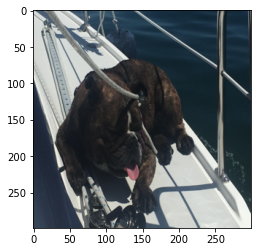

8
original model
['<START>', 'a', 'dog', 'in', 'the', 'snow', '.', '<END>']
augmented model
['<START>', 'a', 'dog', 'is', 'jumping', 'in', 'the', 'air', 'over', 'a', 'bridge', '.', '<END>']


In [125]:
"989851184_9ef368e520.jpg"

def get_roscoe_image(image_name):
    image = PIL.Image.open(os.path.join("/home/bobby/roscoe", image_name))
    return torch.tensor(np.transpose((np.asarray(image.resize((299,299))) / 255.0), axes=(2, 0, 1))).float()                 


for idx in range(len(dev_ro_list)):
    plt.imshow(np.transpose(get_roscoe_image(dev_ro_list[idx]).numpy(), axes=(1, 2, 0)))
    plt.show()
    print(idx)

    print("original model")
    print(image_beam_decoder(orig_word_to_id, orig_id_to_word, caption_model, MAX_LEN, device, 5, [], enc_dev_ro[idx]))
    print("augmented model")
    print(image_beam_decoder(aug_word_to_id, aug_id_to_word, aug_caption_model, MAX_LEN, device, 5, [], enc_dev_ro[idx]))



In [ ]:

ver


## Written Portions

### 2.1.b
Get the average sequence probabilitiy 

In [113]:
def get_mean_seq_prob(seq_log_probs):
    seq_log_probs = torch.stack(seq_log_probs)
    seq_probs = torch.exp(seq_log_probs)
    return torch.mean(seq_probs)

In [117]:
list_seq_log_probs = [greedy_seq_log_probs,
                        beam_3_seq_log_probs,
                        beam_5_seq_log_probs,
                        nucleus_95_seq_log_probs]

In [118]:
for seq_log_probs in list_seq_log_probs:
    print(get_mean_seq_prob(seq_log_probs))

tensor(0.0010, device='cuda:0')
tensor(0.0188)
tensor(0.0216)
tensor(0.0001, device='cuda:0')


thresh hold probability 0.1
['<START>', 'a', 'man', 'wearing', 'a', 'white', 'shirt', 'is', 'holding', 'a', 'microphone', 'whilst', 'holding', 'a', 'beer', 'and', 'white', 'guitar', '.', '<END>']
thresh hold probability 0.5
['<START>', 'a', 'man', 'wearing', 'a', 'white', 'shirt', 'is', 'standing', 'next', 'to', 'a', 'man', 'with', 'a', 'mohawk', 'and', 'sunglasses', '.', '<END>']
thresh hold probability 0.95
['<START>', 'the', 'man', 'is', 'tying', 'a', 'purple', 'guitar', 'and', 'playing', 'with', 'a', 'piece', 'on', 'the', 'counter', '.', '<END>']


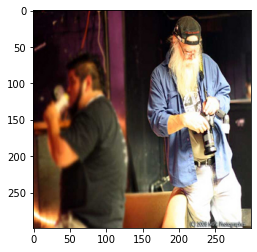

In [126]:
img_idx = 400
plt.imshow(np.transpose(get_image(dev_list[img_idx]).numpy(), axes=(1, 2, 0)))

for p in [0.1, 0.5, 0.95]:
    print("thresh hold probability", p)
    print(image_nucleus_decoder(word_to_id, id_to_word, caption_model, 
                                MAX_LEN, device, p, log_prob, enc_dev[img_idx]))


### 2.1.d
for each 1 of 5 samples:
    Generate 5 seq from nucleus 
    Generate 1 seq from beam-5


nucleus decoder
	 ['<START>', 'people', 'outside', 'basketball', 'for', 'a', 'ball', '.', '<END>']
	 ['<START>', 'someone', 'dancing', 'with', 'basketball', 'players', 'around', '.', '<END>']
	 ['<START>', 'three', 'men', 'are', 'playing', 'hockey', 'on', 'a', 'sport', '.', '<END>']
	 ['<START>', 'men', 'playing', 'basketball', 'and', 'a', 'goalie', 'getting', 'ready', 'to', 'throw', 'the', 'ball', '.', '<END>']
	 ['<START>', 'the', 'three', 'men', 'are', 'playing', 'the', 'basketball', 'from', 'one', 'team', '.', '<END>']
beam-5 decoder
	 ['<START>', 'two', 'men', 'play', 'basketball', '.', '<END>']


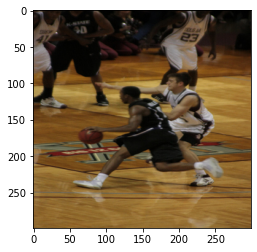

nucleus decoder
	 ['<START>', 'jockeys', ',', 'with', 'oklahoma', 'large', 'crowd', ',', 'while', 'many', 'other', 'people', 'watch', '<END>']
	 ['<START>', 'a', 'group', 'of', 'people', 'fill', 'something', 'cheering', 'at', 'a', 'crowd', '.', '<END>']
	 ['<START>', 'many', 'wrestler', 'are', 'putting', 'their', 'arms', 'in', 'front', 'of', 'a', 'large', 'crowd', 'of', 'spectators', '.', '<END>']
	 ['<START>', 'a', 'group', 'of', 'people', 'cheer', 'the', 'cheer', 'in', 'a', 'stadium', '.', '<END>']
	 ['<START>', 'a', 'crowd', 'of', 'people', 'fill', 'their', 'hands', 'raised', '.', '<END>']
beam-5 decoder
	 ['<START>', 'a', 'crowd', 'of', 'people', 'in', 'a', 'stadium', '.', '<END>']


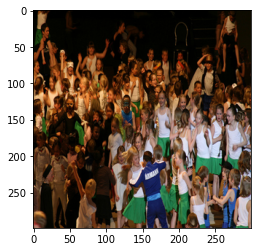

nucleus decoder
	 ['<START>', 'a', 'man', 'wearing', 'a', 'grey', 'hat', 'carrying', 'a', 'cowboy', 'hat', 'stands', 'with', 'another', 'child', 'and', 'a', 'large', 'hat', '.', '<END>']
	 ['<START>', 'a', 'man', 'prepares', 'to', 'throw', 'a', 'corner', '.', '<END>']
	 ['<START>', 'the', 'man', 'in', 'the', 'blue', 'jacket', 'is', 'twirling', 'a', 'straw', 'hat', '.', '<END>']
	 ['<START>', 'a', 'man', 'with', 'arm', 'and', 'brown', 'cap', 'sits', 'on', 'the', 'grass', '.', '<END>']
	 ['<START>', 'the', 'man', 'in', 'the', 'brown', 'top', 'hat', 'and', 'sunglasses', 'sitting', 'on', 'a', 'bench', '.', '<END>']
beam-5 decoder
	 ['<START>', 'a', 'man', 'wearing', 'a', 'cowboy', 'hat', 'sits', 'on', 'the', 'grass', '.', '<END>']


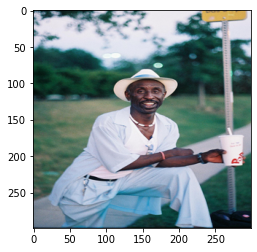

nucleus decoder
	 ['<START>', 'man', 'smiling', '.', '<END>']
	 ['<START>', 'a', 'group', 'of', 'people', 'sitting', 'on', 'top', 'of', 'cliff', 'and', 'rocky', 'elevation', '.', '<END>']
	 ['<START>', 'a', 'man', 'is', 'standing', 'on', 'a', 'mountaintop', '.', '<END>']
	 ['<START>', 'a', 'woman', 'is', 'sitting', 'on', 'rocks', 'staring', 'at', 'the', 'edge', 'of', 'a', 'stream', '.', '<END>']
	 ['<START>', 'the', 'man', 'stands', 'on', 'rocks', 'near', 'a', 'big', 'tree', '.', '<END>']
beam-5 decoder
	 ['<START>', 'a', 'man', 'stands', 'on', 'a', 'cliff', '.', '<END>']


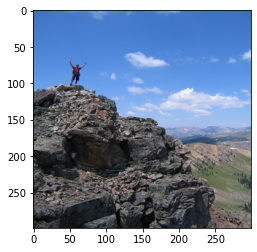

nucleus decoder
	 ['<START>', 'a', 'woman', 'with', 'no', 'shirt', 'and', 'walking', 'sits', 'alone', 'on', 'a', 'green', 'field', 'surrounded', 'by', 'trees', '.', '<END>']
	 ['<START>', 'a', 'young', 'boy', 'walks', 'down', 'a', 'path', 'towards', 'the', 'face', 'first', 'stand', 'on', 'the', 'trees', 'on', 'a', 'pond', '.', '<END>']
	 ['<START>', 'two', 'people', 'running', 'near', 'the', 'trees', 'on', 'a', 'lake', '.', '<END>']
	 ['<START>', 'a', 'girl', 'on', 'a', 'dirt', 'path', 'of', 'some', 'trees', 'and', 'the', 'trees', '.', '<END>']
	 ['<START>', 'a', 'man', 'and', 'a', 'child', 'are', 'sitting', 'on', 'the', 'edge', 'of', 'a', 'grassy', 'field', 'on', 'a', 'park', '.', '<END>']
beam-5 decoder
	 ['<START>', 'a', 'woman', 'walks', 'down', 'a', 'path', 'through', 'the', 'woods', '.', '<END>']


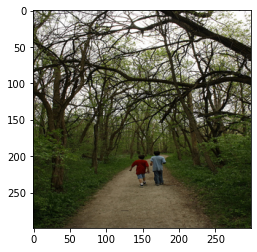

In [133]:
np.random.seed(0)
img_idxes = np.random.randint(len(dev_list), size=5)
for img_idx in img_idxes:
    print("nucleus decoder")
    for _ in range(5):
        print("\t", image_nucleus_decoder(word_to_id, id_to_word, caption_model, 
                                MAX_LEN, device, 0.95, None, enc_dev[img_idx]))
    
    print("beam-5 decoder")
    print("\t", image_beam_decoder(word_to_id, id_to_word, caption_model, 
                       MAX_LEN, device, 5, None, enc_dev[img_idx]))
    plt.imshow(np.transpose(get_image(dev_list[img_idx]).numpy(), axes=(1, 2, 0)))
    plt.show()
